<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Anomaly_Sound_Detection_MobileNet_one_hold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [機械稼働音の異常検知](https://signate.jp/competitions/358)

## Refference

1 [@michelle0915 in AI Dynamics Japan, "クッキー画像でサクッと異常検知AIを作る", Qiita, 2022.09](https://qiita.com/michelle0915/items/28bc5b844bd0d7ab597b)  
2 [AkshatGupt, "Autoencoders in TensorFlow", Kaggle, 2023](https://www.kaggle.com/code/akshat4112/autoencoders-in-tensorflow)  
3 [Autoencoderを使った異常検知を解説！実際の活用事例も紹介](https://www.tryeting.jp/column/627/)  
4 [Tensorflow, "Intro to Autoencoders"](https://www.tensorflow.org/tutorials/generative/autoencoder)

## Import modules

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from icecream import ic

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, losses
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

## Generating Image

In [2]:
datagen = ImageDataGenerator(rescale=1./255, # 255で割ることで正規化
                             zoom_range=0.2, # ランダムにズーム
                             horizontal_flip = True, # 水平反転
                             height_shift_range=0.1,
                            )

In [3]:
IMG_WIDTH:int = 320
IMG_HEIGHT:int = 240
IMG_DEPTH:int = 3

BATCH_SIZE:int = 8

train_dir:str = '../01_input/01_input_300dpi/train'
train_generator = datagen.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode="input", subset='training')

Found 300 images belonging to 1 classes.


In [4]:
ic(train_generator.image_shape)

ic| train_generator.image_shape: (240, 320, 3)


(240, 320, 3)

In [5]:
X_train, y = next(train_generator)
ic(X_train.shape)

ic| X_train.shape: (8, 240, 320, 3)


(8, 240, 320, 3)

## Build the Model

In [6]:
class Autoencoder(Model):
  def __init__(self, shape):
    super(Autoencoder, self).__init__()
    self.shape = shape
    
    self.encoder = tf.keras.Sequential([
      layers.Conv2D(64,(3, 3), padding='same', activation='leaky_relu', input_shape = shape),
      layers.MaxPooling2D(pool_size=(2,2), padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(32,(3, 3), padding='same', activation='sigmoid'),
      layers.MaxPooling2D(pool_size=(2,2), padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(16,(3, 3), padding='same', activation='sigmoid'),
      layers.MaxPooling2D(pool_size=(2,2), padding='same'),
      layers.BatchNormalization(),
      #layers.Conv2D(8,(3, 3), padding='same', activation='sigmoid'),
      #layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    ])
    
    self.decoder = tf.keras.Sequential([
      #layers.Conv2D(8,(3, 3), padding='same', activation='leaky_relu'),
      #layers.UpSampling2D((2, 2)),
      #layers.BatchNormalization(),
      layers.Conv2D(16,(3, 3), padding='same', activation='leaky_relu'),
      layers.UpSampling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Conv2D(32,(3, 3), padding='same', activation='leaky_relu'),
      layers.UpSampling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Conv2D(64,(3, 3), padding='same', activation='leaky_relu'),
      layers.UpSampling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Conv2D(3,(3, 3), padding='same', activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

shape = X_train.shape[1:]
autoencoder = Autoencoder(shape)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-12-10 21:04:55.707796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-10 21:04:55.724774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
adam_low_rate = keras.optimizers.legacy.Adam(learning_rate=1e-5)
autoencoder.compile(optimizer=adam_low_rate, loss=losses.MeanSquaredError())

In [8]:
#Training the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = autoencoder.fit(train_generator, epochs = 500, batch_size = BATCH_SIZE, shuffle=True, callbacks= [callback])

Epoch 1/500


2024-12-10 21:05:31.621402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 30s 580ms/step - loss: 0.1614
Epoch 2/500
38/38 [==============================] - 18s 467ms/step - loss: 0.1252
Epoch 3/500
38/38 [==============================] - 18s 457ms/step - loss: 0.1067
Epoch 4/500
38/38 [==============================] - 18s 461ms/step - loss: 0.0932
Epoch 5/500
38/38 [==============================] - 18s 458ms/step - loss: 0.0844
Epoch 6/500
38/38 [==============================] - 19s 495ms/step - loss: 0.0781
Epoch 7/500
38/38 [==============================] - 19s 477ms/step - loss: 0.0696
Epoch 8/500
38/38 [==============================] - 19s 481ms/step - loss: 0.0654
Epoch 9/500
38/38 [==============================] - 20s 502ms/step - loss: 0.0603
Epoch 10/500
38/38 [==============================] - 19s 480ms/step - loss: 0.0569
Epoch 11/500
38/38 [==============================] - 22s 556ms/step - loss: 0.0535
Epoch 12/500
38/38 [==============================] - 20s 499ms/step - loss: 0.0496
Epoch 13/500


Ref:[Subclassing tf.keras.models.Model save_model saves h5py but not h5/hdf5 file types
#29545](https://github.com/tensorflow/tensorflow/issues/29545)

In [9]:
import datetime
autoencoder.save('../04_model/autoencoder'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), save_format='tf')

INFO:tensorflow:Assets written to: ../04_model/autoencoder20241210-195510/assets


INFO:tensorflow:Assets written to: ../04_model/autoencoder20241210-195510/assets


## Validation Training data

In [9]:
train_origin_datagen = ImageDataGenerator(rescale=1./255) # 255で割ることで正規化
generator = train_origin_datagen.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode="input")

Found 300 images belonging to 1 classes.


In [10]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on validation data")
results = autoencoder.evaluate(generator)
print("valid loss:", results)

Evaluate on validation data


2024-12-10 23:24:22.545391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 20s 468ms/step - loss: 0.0046
valid loss: 0.004597633145749569


In [11]:
# Generate predictions
print("Generate predictions for samples")
predictions = autoencoder.predict(generator)
print("predictions shape:", predictions.shape[1:4])

Generate predictions for samples


2024-12-10 23:24:45.890578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 14s 366ms/step
predictions shape: (240, 320, 3)


ic| generator.image_shape: (240, 320, 3)


38/38 [==============================] - 14s 375ms/step


ic| gen_items.shape: (300, 240, 320, 3)


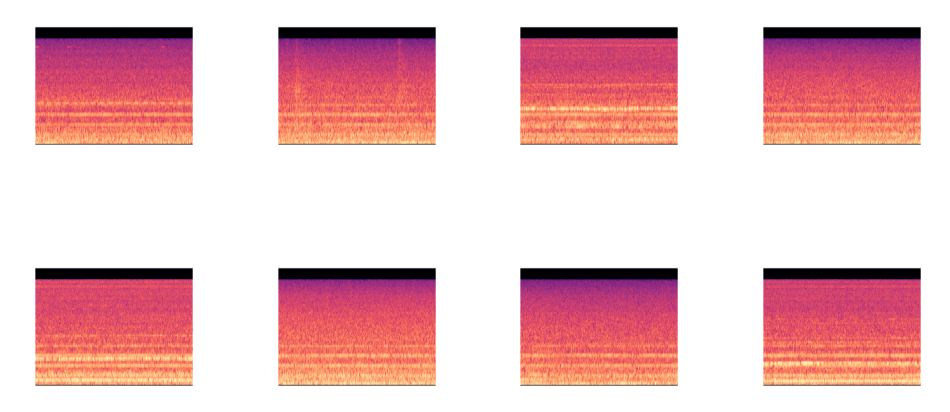

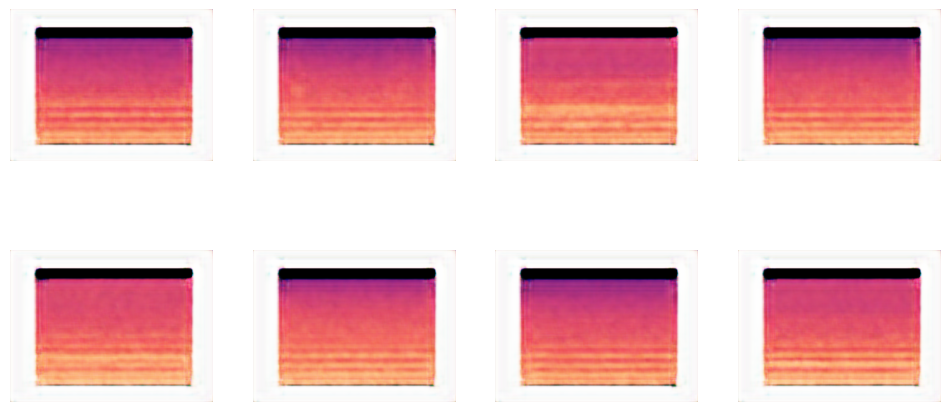

In [12]:
import matplotlib.pyplot as plt
import cv2
# 1バッチ分取り出す(64個の画像）
items = next(iter(generator))
ic(generator.image_shape)

plt.figure(figsize=(12,12))
for i, image in enumerate(items[0][:BATCH_SIZE], 1):
    plt.subplot(4,4,i)
    plt.imshow(image)
    plt.axis('off')

gen_items = autoencoder.predict(generator)
ic(gen_items.shape)

plt.figure(figsize=(12,12))
for i, gen_img in enumerate(gen_items[:BATCH_SIZE], 1):
    plt.subplot(4,4,i)
    plt.imshow(gen_img)
    plt.axis('off')

## valid normal

In [23]:
valid_normal_dir:str = '../01_input/01_input_300dpi/valid/normal'
valid_normal_datagen = ImageDataGenerator(rescale=1./255) # 255で割ることで正規化
valid_normal_generator = valid_normal_datagen.flow_from_directory(valid_normal_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode="input")

Found 150 images belonging to 1 classes.


ic| valid_normal_generator.image_shape: (240, 320, 3)


19/19 [==============================] - 7s 380ms/step


ic| gen_items.shape: (150, 240, 320, 3)


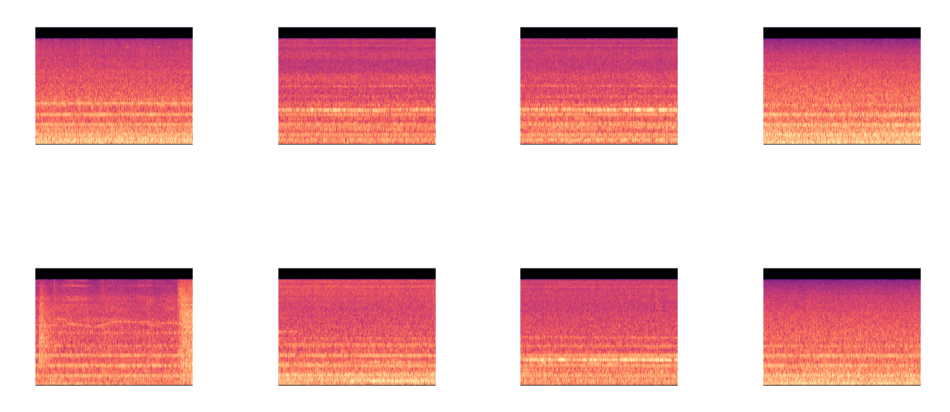

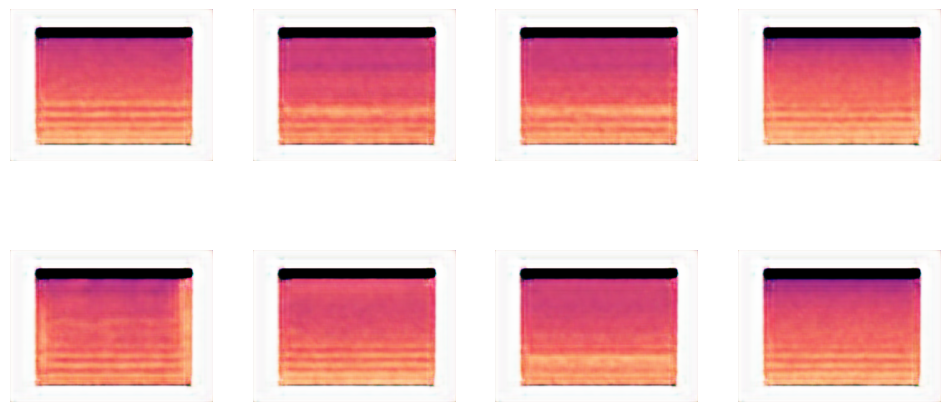

In [24]:
import matplotlib.pyplot as plt
import cv2
# 1バッチ分取り出す
items = next(iter(valid_normal_generator))
ic(valid_normal_generator.image_shape)

plt.figure(figsize=(12,12))
for i, image in enumerate(items[0][:BATCH_SIZE], 1):
    plt.subplot(4,4,i)
    plt.imshow(image)
    plt.axis('off')

gen_items = autoencoder.predict(valid_normal_generator)
ic(gen_items.shape)

plt.figure(figsize=(12,12))
for i, gen_img in enumerate(gen_items[:BATCH_SIZE], 1):
    plt.subplot(4,4,i)
    plt.imshow(gen_img)
    plt.axis('off')

## valid anomaly

In [25]:
valid_anomaly_dir:str = '../01_input/01_input_300dpi/valid/anomaly'
valid_anomaly_datagen = ImageDataGenerator(rescale=1./255) # 255で割ることで正規化
valid_anomaly_generator = valid_anomaly_datagen.flow_from_directory(valid_anomaly_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode="input")

Found 50 images belonging to 1 classes.


ic| valid_anomaly_generator.image_shape: (240, 320, 3)


7/7 [==============================] - 4s 318ms/step


ic| gen_items.shape: (50, 240, 320, 3)


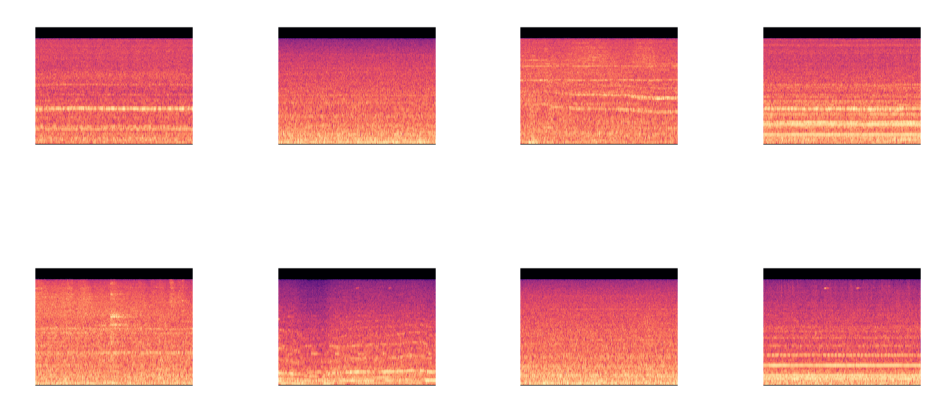

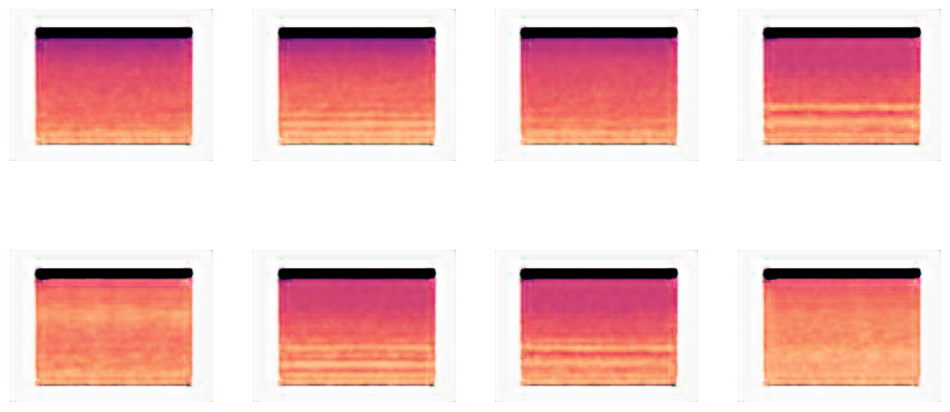

In [27]:
import matplotlib.pyplot as plt
import cv2
# 1バッチ分取り出す
items = next(iter(valid_anomaly_generator))
ic(valid_anomaly_generator.image_shape)

plt.figure(figsize=(12,12))
for i, image in enumerate(items[0][:BATCH_SIZE], 1):
    plt.subplot(4,4,i)
    plt.imshow(image)
    plt.axis('off')

gen_items = autoencoder.predict(valid_anomaly_generator)
ic(gen_items.shape)

plt.figure(figsize=(12,12))
for i, gen_img in enumerate(gen_items[:BATCH_SIZE], 1):
    plt.subplot(4,4,i)
    plt.imshow(gen_img)
    plt.axis('off')

## To Output Submitting CSV